# Data Loading and preprocessing

In [50]:
import os
import random
import shutil

# Function to move files from source to destination directory
def move_files(source_dir, destination_dir, file_list):
    for file in file_list:
        src = os.path.join(source_dir, file)
        dst = os.path.join(destination_dir, file)
        shutil.copy(src, dst)

# Directory containing labeled data
labeled_data_dir = "dataset/FER2013/train"

# Directory to store labeled data for different scenarios
labeled_scenarios_dir = "dataset/FER2013/labeled_scenarios"

# Directory to store unlabeled data
unlabeled_data_dir = "dataset/FER2013/unlabeled"

# List of emotions
emotions = os.listdir(labeled_data_dir)

# Number of labeled samples for each scenario
num_labeled_samples = [10, 25, 100, 250]
# Initialize a set to store all labeled files
all_labeled_files = set()

# Iterate over each scenario
for num_samples in num_labeled_samples:
    # Create a directory for the current scenario
    scenario_dir = os.path.join(labeled_scenarios_dir, f"{num_samples}_labeled")
    os.makedirs(scenario_dir, exist_ok=True)
    
    # Iterate over each emotion
    for emotion in emotions:
        # Get the path to the emotion directory
        emotion_dir = os.path.join(labeled_data_dir, emotion)
        
        # Check if the directory exists and is a directory
        if os.path.isdir(emotion_dir) and not emotion == '.ipynb_checkpoints':
            # Create a directory for the current emotion within the scenario directory
            emotion_scenario_dir = os.path.join(scenario_dir, emotion)
            os.makedirs(emotion_scenario_dir, exist_ok=True)
            # List all image files for the current emotion, excluding .DS_Store
            image_files = [f for f in os.listdir(emotion_dir) if not f.startswith('.')]
            # Randomly select num_samples for labeling
            labeled_files = random.sample(image_files, num_samples)
            # Move the labeled files to the labeled directory
            move_files(emotion_dir, emotion_scenario_dir, labeled_files)
            # Add the labeled files to the set of all labeled files
            all_labeled_files.update(labeled_files)
        else:
            print(f"Directory '{emotion_dir}' does not exist or is not a directory.")

# Create the unlabeled directory if it doesn't exist
os.makedirs(unlabeled_data_dir, exist_ok=True) 

# Move the remaining files to the unlabeled directory
for emotion in emotions:
    emotion_dir = os.path.join(labeled_data_dir, emotion)
    if not emotion == '.ipynb_checkpoints' and os.path.isdir(emotion_dir) :
        # List all files (excluding directories) for the current emotion
        remaining_files = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f)) and not f.startswith('.')]
        # unlabeled_files = random.sample(remaining_files, 10)
        move_files(emotion_dir, unlabeled_data_dir, remaining_files)
    else:
        print(f"Directory '{emotion_dir}' does not exist or is not a directory.")


Directory 'dataset/FER2013/train/.DS_Store' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.ipynb_checkpoints' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.DS_Store' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.ipynb_checkpoints' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.DS_Store' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.ipynb_checkpoints' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.DS_Store' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.ipynb_checkpoints' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.DS_Store' does not exist or is not a directory.
Directory 'dataset/FER2013/train/.ipynb_checkpoints' does not exist or is not a directory.


# Data Augmentation

In [68]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for labeled and unlabeled data
labeled_data_root_dir = "dataset/FER2013/labeled_scenarios"
unlabeled_data_dir = "dataset/FER2013/unlabeled"
test_data_dir = "dataset/FER2013/test"

# Define image dimensions and batch size
img_width, img_height = 64, 64
batch_size = 70

# List of scenarios
scenarios = ["10_labeled", "25_labeled", "100_labeled", "250_labeled"]

# Use ImageDataGenerator for data augmentation and loading
datagen = ImageDataGenerator(rescale=1.0/255)

# Load labeled data for each scenario
labeled_data_generators = {}
for scenario in scenarios:
    scenario_dir = os.path.join(labeled_data_root_dir, scenario)
    labeled_data_generator = datagen.flow_from_directory(
        scenario_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale'
    )
    labeled_data_generators[scenario] = labeled_data_generator

# Load unlabeled data without data augmentation
unlabeled_data_generator = tf.keras.preprocessing.image_dataset_from_directory(
    directory=unlabeled_data_dir,
    labels=None,  # No labels for unlabeled data
    label_mode=None,  # Set label_mode to None for unlabeled data
    batch_size=batch_size,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False
)

# Load test data
test_data_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

dataset/FER2013/labeled_scenarios/10_labeled
Found 70 images belonging to 7 classes.
dataset/FER2013/labeled_scenarios/25_labeled
Found 175 images belonging to 7 classes.
dataset/FER2013/labeled_scenarios/100_labeled
Found 700 images belonging to 7 classes.
dataset/FER2013/labeled_scenarios/250_labeled
Found 1750 images belonging to 7 classes.
Found 28707 files.
Found 7180 images belonging to 7 classes.


# Define CNN model

In [129]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# Define CNN model architecture
def create_model(input_shape):
    cnn_model = Sequential()

    cnn_model.add(Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu', input_shape=(48, 48, 1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Dense(7, activation='softmax'))

    cnn_model.summary()

    return model

# Define hyperparameters
img_width, img_height = 64, 64
batch_size = 70

# Temporal ensembling semi-supervised method implementation

In [136]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define optimizer
optimizer = Adam()

num_epochs=60

model = create_model((img_width, img_height, 1))

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Load labeled data generator for the current scenario
labeled_data_generator = labeled_data_generators["250_labeled"]
total_labeled_samples = 1750
total_unlabeled_samples = 28707
# Create iterators for labeled and unlabeled data generators
labeled_iterator = iter(labeled_data_generator)
unlabeled_iterator = iter(unlabeled_data_generator)

total_labeled_batches = total_labeled_samples // batch_size
total_unlabeled_batches = total_unlabeled_samples // batch_size

# Calculate the total number of batches
total_batches = min(total_labeled_batches, total_unlabeled_batches)

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []


# Loop through epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Reset iterators
    labeled_iterator = iter(labeled_data_generator)
    unlabeled_iterator = iter(unlabeled_data_generator)
    
    total_loss_epoch = 0
    all_labeled_predictions = []
    all_labeled_labels = []
    
    for batch_nr in range(total_batches):
        
        # Initialize variables for labeled and unlabeled data
        labeled_images, labeled_labels = None, None
        unlabeled_images = None

        # Get labeled data batch
        if batch_nr < total_labeled_batches:
            labeled_images, labeled_labels = next(labeled_iterator)

        # Get unlabeled data batch
        if batch_nr < total_unlabeled_batches:
            unlabeled_images = next(unlabeled_iterator)
            
        # Train the model on labeled data
        with tf.GradientTape() as tape:
            labeled_predictions = model(labeled_images)
            labeled_loss = tf.keras.losses.categorical_crossentropy(labeled_labels, labeled_predictions)
        
        gradients = tape.gradient(labeled_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update the model's predictions on unlabeled data
        unlabeled_predictions = model(unlabeled_images)
        
        # Accumulate the predictions and labels for calculating training accuracy
        all_labeled_predictions.append(labeled_predictions)
        all_labeled_labels.append(labeled_labels)
        
        # Accumulate the predictions for ensembling
        if epoch == 0:
            all_unlabeled_predictions = unlabeled_predictions.numpy()
        else:
            all_unlabeled_predictions += unlabeled_predictions.numpy()


    # Calculate the average predictions for ensembling
    all_unlabeled_predictions /= total_batches*batch_size

    # Compute consistency loss and total loss
    with tf.GradientTape() as tape:
        labeled_predictions = model(labeled_images)
        labeled_loss = tf.keras.losses.categorical_crossentropy(labeled_labels, labeled_predictions)
        consistency_loss = tf.keras.losses.mean_squared_error(unlabeled_predictions[:len(labeled_predictions)], all_unlabeled_predictions[:len(labeled_predictions)])
        total_loss = labeled_loss + consistency_loss
        total_loss_epoch += total_loss.numpy()

    # Average total loss across batches in the epoch
    average_loss = total_loss_epoch / total_batches
    average_loss = np.mean(average_loss[0])
    train_loss_history.append(average_loss)
    
    # Backpropagate and update the model
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


    # Concatenate predictions and labels across all batches
    all_labeled_predictions = np.concatenate(all_labeled_predictions, axis=0)
    all_labeled_labels = np.concatenate(all_labeled_labels, axis=0)
    
    # Calculate training accuracy for the epoch
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy.update_state(all_labeled_labels, all_labeled_predictions)
    train_accuracy_history.append(train_accuracy.result().numpy())
    
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_data_generator, steps=len(test_data_generator))
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)


    # Print the test loss and accuracy
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

/Users/balakumaransivarajan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_141 (Conv2D)             │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 24, 24, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 12, 12, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_138               │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,239 (5.05 MB)

 Trainable params: 1,322,919 (5.05 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3840 - loss: 6.0948
Epoch 1, Test Loss: 6.137180328369141, Test Accuracy: 0.37827298045158386
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3764 - loss: 6.1572
Epoch 2, Test Loss: 6.2769694328308105, Test Accuracy: 0.3653203248977661
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3708 - loss: 6.3803
Epoch 3, Test Loss: 6.343330383300781, Test Accuracy: 0.36754873394966125
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3756 - loss: 6.2326
Epoch 4, Test Loss: 6.373045444488525, Test Accuracy: 0.37534818053245544
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3726 - loss: 6.4439
Epoch 5, Test Loss: 6.45935583114624, Test Accuracy: 0.3725626766681671
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3738 - loss: 6.4664
Epoch 6, Test Loss: 6.516735553741455, Test Accuracy: 0.37465181946754456
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━

# Saving model

In [137]:
savedmodelsdir = "saved_models"
# Create the directory if it doesn't exist
os.makedirs(savedmodelsdir, exist_ok=True)
model_path = "saved_models/model_250_labels_per_each_class.h5"
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


# Model Evaluation

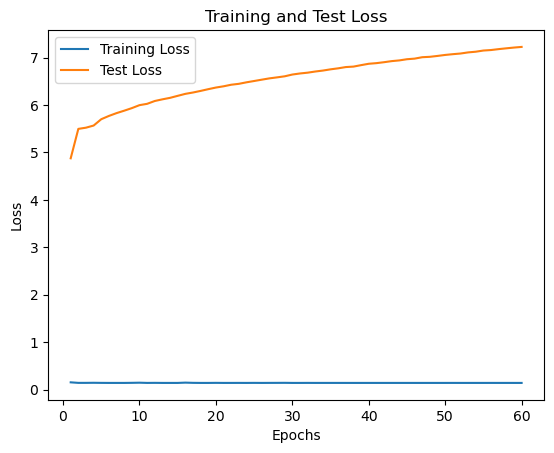

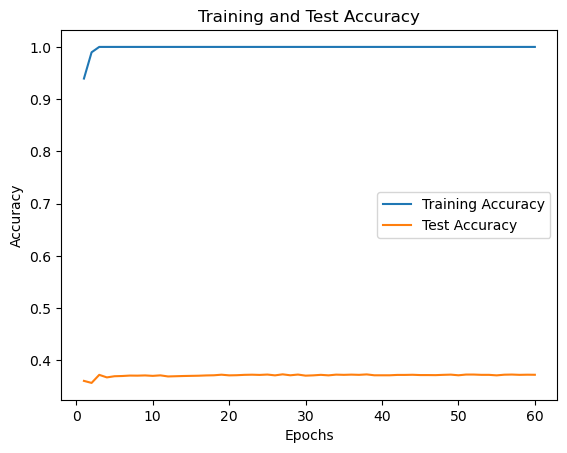

In [133]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot training and test loss
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, test_loss_history, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and test accuracy
plt.plot(epochs, train_accuracy_history, label='Training Accuracy')
plt.plot(epochs, test_accuracy_history, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


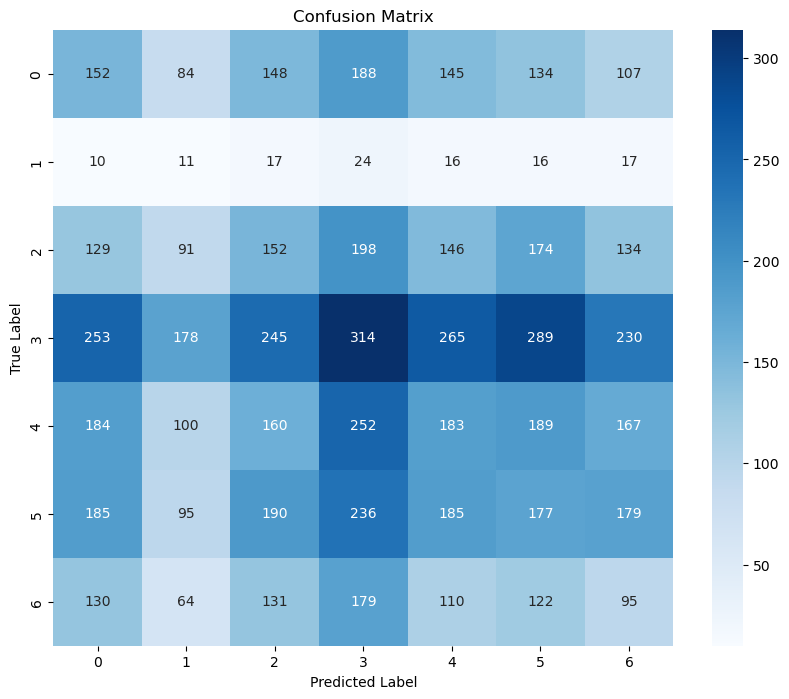

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test data
y_pred = model.predict(test_data_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_data_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


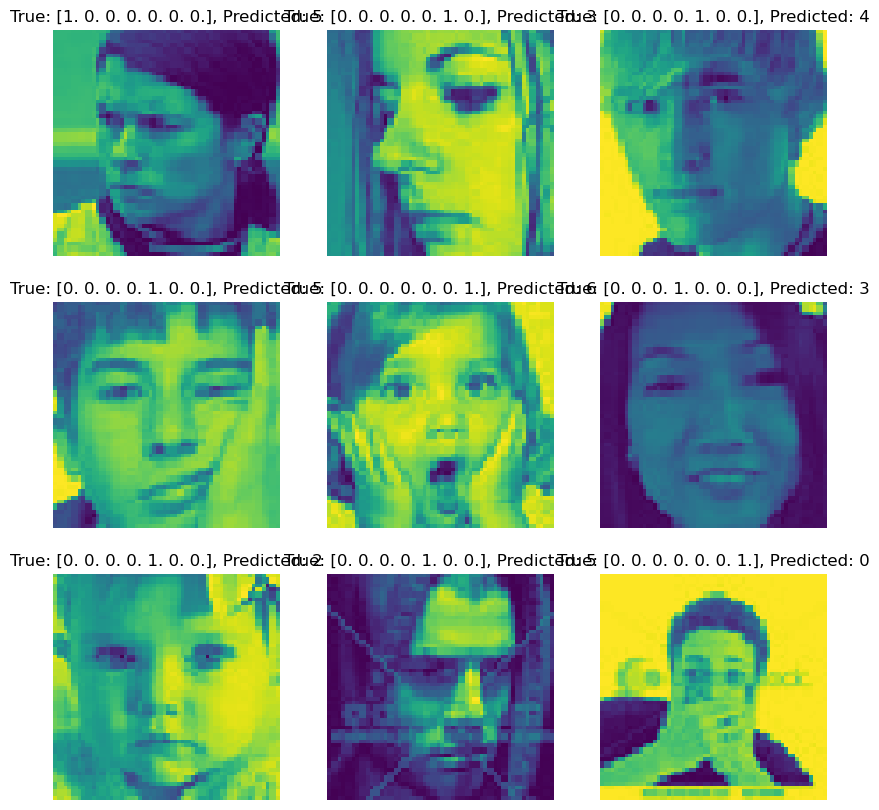

In [134]:
# Get a batch of test images and their true labels
test_images, true_labels = next(test_data_generator)

# Make predictions on the batch
predictions = model.predict(test_images)

# Plot sample images with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_labels[i]}, Predicted: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()

In [135]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_true_classes, y_pred_classes)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.15      0.16      0.15       958
           1       0.02      0.10      0.03       111
           2       0.15      0.15      0.15      1024
           3       0.23      0.18      0.20      1774
           4       0.17      0.15      0.16      1235
           5       0.16      0.14      0.15      1247
           6       0.10      0.11      0.11       831

    accuracy                           0.15      7180
   macro avg       0.14      0.14      0.14      7180
weighted avg       0.17      0.15      0.16      7180

